<a href="https://colab.research.google.com/github/AshisRay/FoSC/blob/main/FoSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
df_pro = pd.read_excel('/content/drive/MyDrive/Ascii/food production.xlsx')
df_con = pd.read_excel('/content/drive/MyDrive/Ascii/food consumption.xlsx')
df_pro

,Date,State,Food Production(in million metric tons)
0,2021-01-01,Andhra Pradesh,0.61
1,2021-02-01,Andhra Pradesh,1.00
2,2021-03-01,Andhra Pradesh,0.83
3,2021-04-01,Andhra Pradesh,0.81
4,2021-05-01,Andhra Pradesh,0.89
...,...,...,...
135,2021-01-01,West Bengal,1.40
136,2021-02-01,West Bengal,1.46
137,2021-03-01,West Bengal,1.48
138,2021-04-01,West Bengal,1.49


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df_con

,Date,State,Food Consumption(in million metric tons)
0,2021-01-01,Andhra Pradesh,0.40
1,2021-02-01,Andhra Pradesh,0.50
2,2021-03-01,Andhra Pradesh,0.55
3,2021-04-01,Andhra Pradesh,0.60
4,2021-05-01,Andhra Pradesh,0.60
...,...,...,...
135,2021-01-01,West Bengal,1.00
136,2021-02-01,West Bengal,1.40
137,2021-03-01,West Bengal,1.50
138,2021-04-01,West Bengal,1.45


In [8]:
df_pro['Date'] = pd.to_datetime(df_pro['Date'])
df_con['Date'] = pd.to_datetime(df_con['Date'])

In [9]:
df_diff = df_pro
df_diff = df_diff.rename(columns={'Food Production(in million metric tons)' : 'Difference'})

In [10]:
df_diff['Difference'] = df_diff['Difference'] - df_con['Food Consumption(in million metric tons)']
df_diff

,Date,State,Difference
0,2021-01-01,Andhra Pradesh,0.21
1,2021-02-01,Andhra Pradesh,0.50
2,2021-03-01,Andhra Pradesh,0.28
3,2021-04-01,Andhra Pradesh,0.21
4,2021-05-01,Andhra Pradesh,0.29
...,...,...,...
135,2021-01-01,West Bengal,0.40
136,2021-02-01,West Bengal,0.06
137,2021-03-01,West Bengal,-0.02
138,2021-04-01,West Bengal,0.04


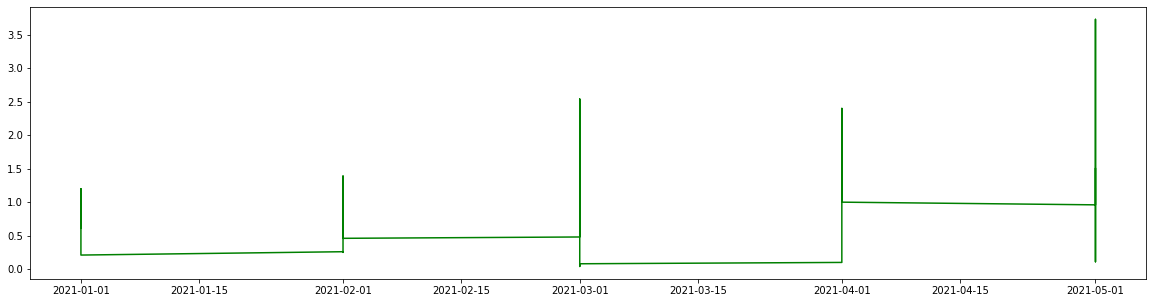

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))

plt.plot(df_pro['Date'].sort_values() , df_pro['Food Production(in million metric tons)'] , color='g')

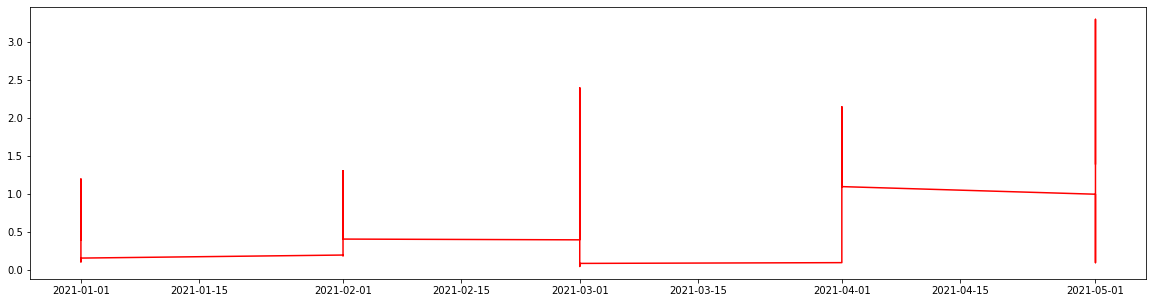

In [12]:
plt.figure(figsize=(20,5))
plt.plot(df_con['Date'].sort_values() , df_con['Food Consumption(in million metric tons)'] , color='r')

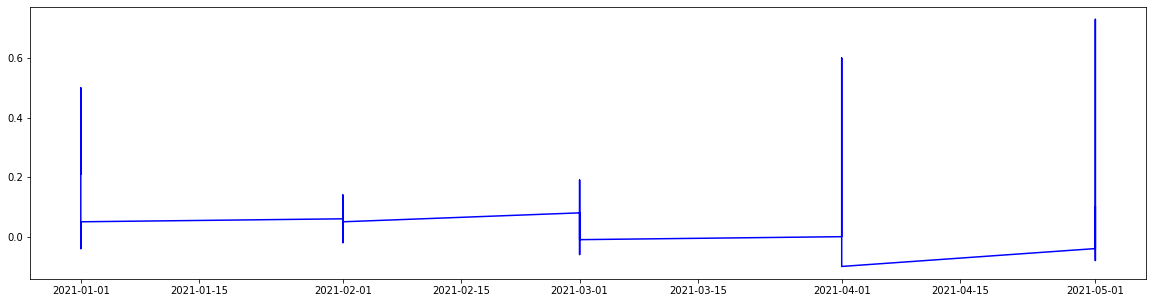

In [13]:
plt.figure(figsize=(20,5))
plt.plot(df_diff['Date'].sort_values() , df_diff['Difference'] , color='b')

In [14]:
df_diff = df_diff.rename(columns ={'Difference':'y','Date':'ds'})

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


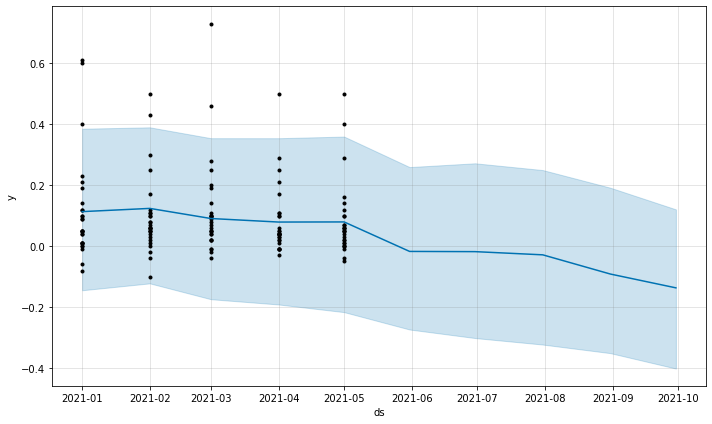

In [15]:
from fbprophet import Prophet
model = Prophet(interval_width=0.95 ,weekly_seasonality=True)
model.fit(df_diff)
model.component_modes
future_dates = model.make_future_dataframe(periods=5,freq='M',include_history=True)
prediction = model.predict(future_dates)
plot1 = model.plot(prediction[['ds','yhat_lower','trend','yhat_upper','yhat']])

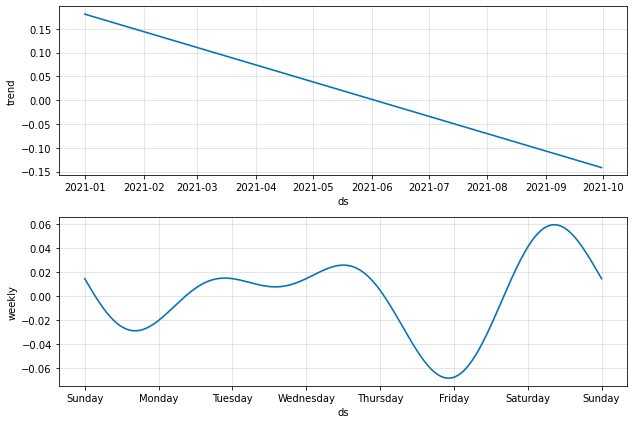

In [16]:
plot2 = model.plot_components(prediction)

In [19]:
df_diff['ds'].nunique()

5

In [20]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model,initial='60 days' ,period='1 days' ,horizon='30 days')
df_cv.head()
df_cv.shape

INFO:fbprophet:Making 31 forecasts with cutoffs between 2021-03-02 00:00:00 and 2021-04-01 00:00:00


(868, 6)

In [21]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,4 days,0.013969,0.118191,0.067608,0.606743,0.964286
1,5 days,0.013969,0.118191,0.067608,0.606743,0.964286
2,6 days,0.013969,0.118191,0.067608,0.606743,0.964286
3,7 days,0.013969,0.118191,0.067608,0.606743,0.964286
4,8 days,0.013969,0.118191,0.067608,0.606743,0.964286


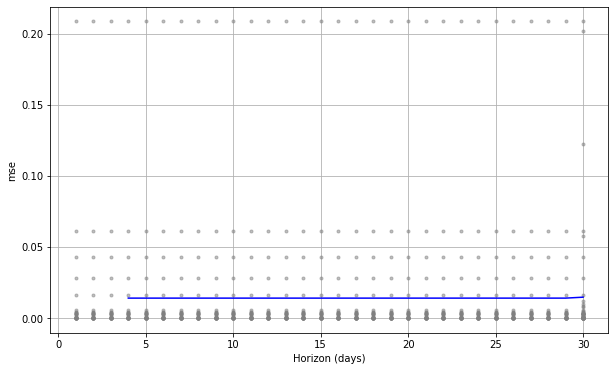

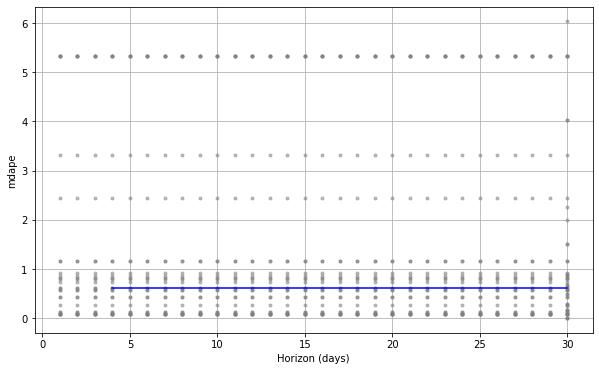

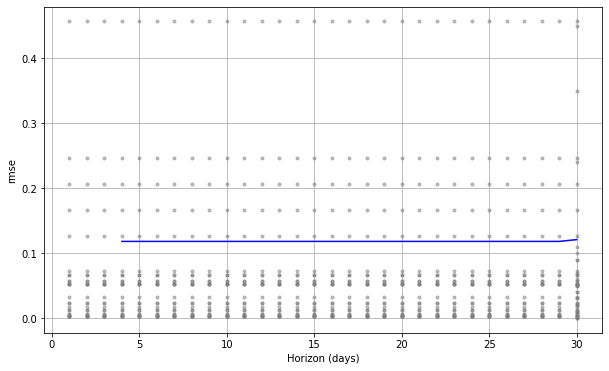

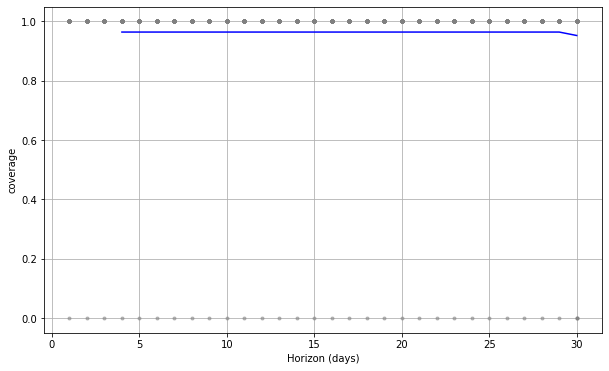

In [22]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv ,metric='mse')
fig = plot_cross_validation_metric(df_cv ,metric='mdape')
fig = plot_cross_validation_metric(df_cv ,metric='rmse')
fig = plot_cross_validation_metric(df_cv ,metric='coverage')

In [23]:
import numpy as np
array = np.unique(df_diff['State'])
df_diff['State'].value_counts()
list1 = []
list2 = []
for i in range(0,28):
  df_count = df_diff
  df_count = df_count[df_count['State'] == array[i]]
  sum = df_count['y'].sum()
  list1.append(sum)
  list2.append(array[i])
data_cnf = pd.DataFrame(list(zip(list2,list1)), columns=['State','Difference'])
data_cnf.head()
data_cnf.to_excel('difference.xls',index=False)
print("THE HIGHEST SURPLUSS IS : {0} million metric tons".format(np.max(data_cnf['Difference'])))
data_cnf.loc[data_cnf['Difference'] == np.max(data_cnf['Difference']) ]

THE HIGHEST SURPLUSS IS : 2.4899999999999998 million metric tons


,State,Difference
25,Uttar Pradesh,2.49


In [24]:
print("THE MOST DEFICIET IS : {0} million metric tons".format(np.min(data_cnf['Difference'])))
data_cnf.loc[data_cnf['Difference'] == np.min(data_cnf['Difference']) ]

THE MOST DEFICIET IS : -0.12000000000000001 million metric tons


,State,Difference
16,Mizoram,-0.12


In [26]:
data_cnf.loc[data_cnf['Difference'] == data_cnf['Difference'] ]

,State,Difference
0,Andhra Pradesh,1.49
1,Arunachal Pradesh,0.28
2,Assam,0.25
3,Bihar,0.38
4,Chhattisgarh,0.51
5,Goa,0.34
6,Gujarat,0.04
7,Haryana,0.36
8,Himachal Pradesh,0.33
9,Jharkhand,0.53
